<a href="https://colab.research.google.com/github/siva4iov/FlatsPrice_DS_Proj/blob/master/Predictions_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictions Visualization

In this notebook I'm going to generate some synthetic data based on dataset, make predictions on new data, and then visualize this predictions on a map

In [50]:
!pip install geopandas
!pip install Shapely
!pip install sdv
!pip install catboost
import shapely
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
from google.colab import files
if not os.path.exists("/content/kazan.geojson"):
    files.upload()
if not os.path.exists("/content/dataset_clean_full_2.csv"):
    files.upload()
if not os.path.exists("/content/processed_dataset.csv"):
    files.upload()
if not os.path.exists("/content/model"): # trained model
    files.upload()
if not os.path.exists("/content/ct"): # pipeline for normalizing data
    files.upload()

In [52]:
layer = gpd.read_file("kazan.geojson")

In [53]:
df = pd.read_csv("dataset_clean_full_2.csv", sep=";")
p_df = pd.read_csv("processed_dataset.csv")
df.head()

,Living_space,Num_of_rooms,Renovation,Price,Total_area,Kitchen_area,Floor,Appliances_2,Appliances_3,Appliances_4,...,coord,latitude,longitude,district_1,district_2,district_3,district_4,district_5,district_6,district_7
0,20.000000,1,1,27000.0,39.0,12.0,10,1,0,0,...,"(55.7978535, 49.1793271)",55.797854,49.179327,1,0,0,0,0,0,0
1,16.411765,1,1,14000.0,18.0,7.0,9,0,0,0,...,"(55.77585095, 49.1077901578817)",55.775851,49.107790,0,1,0,0,0,0,0
2,75.453998,3,2,40000.0,105.0,25.0,2,1,1,1,...,"(55.731757599999995, 49.169174993589834)",55.731758,49.169175,0,0,1,0,0,0,0
3,13.500000,1,2,20000.0,45.0,17.5,5,1,1,1,...,"(55.816227350000005, 49.13680551681148)",55.816227,49.136806,0,0,0,1,0,0,0
4,24.000000,1,2,22000.0,36.0,6.0,10,1,1,1,...,"(55.8252666, 49.1468802)",55.825267,49.146880,0,0,0,1,0,0,0


# Make a grid based on map

I'm going to visualize mean price in every "box", that will make illustrations more pretty

In [54]:
kazan_polygon = list(layer.geometry[0].geoms)[1]

Functions for creating grid

In [55]:
from shapely.geometry import Polygon
from shapely.prepared import prep


def grid_bounds(geom, delta):
    minx, miny, maxx, maxy = geom.bounds
    nx = int((maxx - minx )/delta)
    ny = int((maxy - miny )/delta)
    gx, gy = np.linspace(minx,maxx,nx), np.linspace(miny,maxy,ny)
    grid = []
    for i in range(len(gx)-1):
        m_grid = []
        for j in range(len(gy)-1):
            poly_ij = Polygon([[gx[i],gy[j]],[gx[i],gy[j+1]],[gx[i+1],gy[j+1]],[gx[i+1],gy[j]]])
            m_grid.append( poly_ij )
        grid.append(m_grid)
    return np.array(grid).T[::-1, :]


def partition(geom, delta):
    prepared_geom = prep(geom)
    grid = list(filter(prepared_geom.intersects, grid_bounds(geom, delta).flatten()))
    return grid

In [56]:
geom = kazan_polygon
grid = partition(geom, 0.03)

## Map with the grid
These "boxes" will be used as districts, I will calculate mean for every box and visualize it through color

<AxesSubplot:>

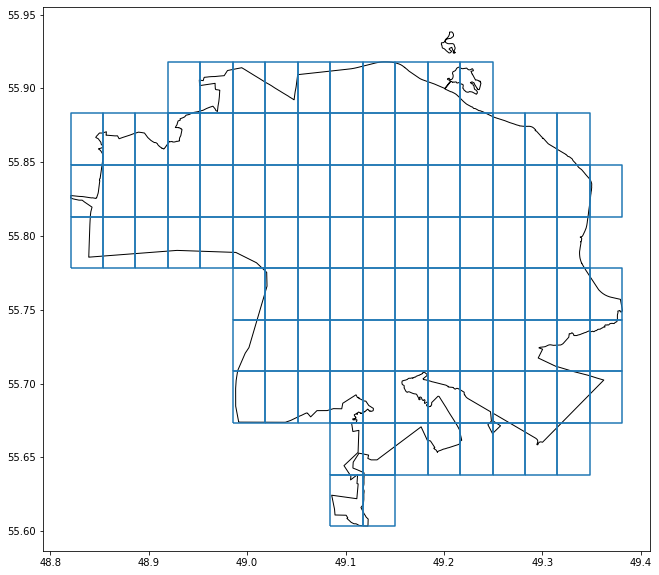

In [57]:
fig, ax = plt.subplots(figsize=(15, 10))
gpd.GeoSeries(grid).boundary.plot(ax=ax)
layer.plot(ax = ax, color='white', edgecolor='black', aspect=1.5)

## Calculations
Here are functions for calculationg mean values for each "box"(polygon)

In [58]:
from shapely.geometry import Point

def get_points(df):
  points = []
  values = np.concatenate([df.loc[:, ["longitude", "latitude"]].values,
                          df.index.values[np.newaxis].T], axis=1)
  for value in values:
    point = Point(value[0], value[1])
    ind = value[2]
    points.append((point, ind))
  return points

def get_polys(boundaries):
  boundaries = [np.array(value.coords) for value in boundaries]
  polys = [Polygon(value) for value in boundaries]
  return polys

def mean_for_polygon(df, points, polygons):
    mean_for_poly = []
    for polygon in polygons:
      pts_in_poly = [value[1] for value in points if polygon.contains(value[0])]
      means = df.loc[pts_in_poly]["Price"].mean()/1000
      mean_for_poly.append(means)
    return mean_for_poly


In [59]:
gr_bounds = grid_bounds(geom, 0.03).flatten()

points = get_points(df)
polys = get_polys(gpd.GeoSeries(gr_bounds).boundary)
# I will use size of polygon for generating new data
coords = np.array(list(polys[0].boundary.coords))
poly_width = coords[:,0].max() - coords[:,0].min()
poly_height = coords[:,1].max() - coords[:,1].min()
print(f'Poly width: {poly_width:,.3}')
print(f'Poly height: {poly_height:,.3}')
mean_prices = mean_for_polygon(df, points, polys)
gdf_p = gpd.GeoDataFrame(np.concatenate([np.array(polys)[:, np.newaxis], np.array(mean_prices)[:, np.newaxis]], axis=1),
                         columns=["geometry", 'mean_price'])
gdf_p.loc[:, 'mean_price'] = gdf_p["mean_price"].astype(np.float64)

Poly width: 0.033
Poly height: 0.0349


## Map with mean prices


This map barely covers City area, I will increase num of boxes using my ML model

<AxesSubplot:>

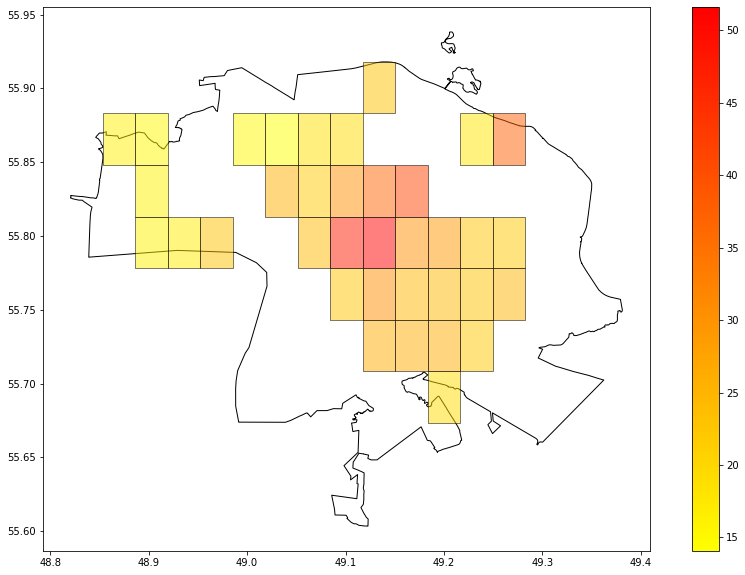

In [60]:
fig, ax = plt.subplots(figsize=(15, 10))
layer.plot(ax = ax, color='white', edgecolor='black', aspect=1.5)
gdf_p.plot(ax=ax, alpha=0.5, column='mean_price', legend=True, edgecolor="black", cmap="autumn_r", aspect=1.5)

I will "expand" this grid a little

My idea is to take polygons which have at least 2 neighbours(left, right, up or down). Take rows from df at this neighbours polygons. Generate df based on this rows, make predictions, and then visualize this data

### Function for calculating distance to metro or city center

I will take features from neighbours such as `area` or `num_of_rooms`, but coordinates must be different, so I will need to calculate distance to Metro or CityCenter again on this new data

In [61]:
from geopy.distance import geodesic as GD

metro = [
    [55.74437098345888, 49.21842147085857],
    [55.75005848187576, 49.20874803385248],
    [55.759933872926894, 49.19165479076522],
    [55.765435, 49.165143],
    [55.77690597053148, 49.142589131055516],
    [55.787108350131085, 49.122054609493496],
    [55.7959302953497, 49.1062780870964],
    [55.81666978747769, 49.09852469080619],
    [55.82716721066275, 49.08321529204553]
]
metro = np.array(metro)

city_center = [[55.787602, 49.121079]]
city_center = np.array(city_center)


def calc_distances(values: np.ndarray) -> pd.DataFrame:
  distances = []
  min_d = None
  for coords in values:
    for st in metro:
      d = GD(coords, st).km
      if (min_d is None) or d < min_d:
        min_d = d
    cc_d = GD(coords, city_center[0]).km
    distances.append([min_d, cc_d])
    min_d = None
  distances = np.array(distances)
  return pd.DataFrame(distances, columns=["Metro_d", "Center_d"])


# Model for predictions
Uploading trained model, and pipeline from previous notebook.
I will write a function to transform generated dataset to format for model, and then make predictions

In [62]:
import pickle
with open("model", "rb") as file:
  model = pickle.loads(file.read())

with open("ct", "rb") as file:
  ct = pickle.loads(file.read())

ct.fit(p_df)
def make_predictions(df):
  X = ct.transform(df)
  preds = model.predict(X)
  return preds

## Generating data

SDV library for creating synthetic dataset

In [94]:
from sdv.tabular import GaussianCopula
from random import randint

grid = grid_bounds(geom, 0.03)
mean_prices = np.array(mean_for_polygon(df, points, polys)).reshape(grid.shape)

def generate_new_data():
  polys = []
  means = []
  poly_w, poly_h = int(poly_width*10e4), int(poly_height*10e4)
  rows, cols = mean_prices.shape
  for i in range(rows):
    for k in range(cols):
      
      if np.isnan(mean_prices[i, k]):
        neighs = []
      
        if i <= rows-2:
          if not np.isnan(mean_prices[i+1, k]):
            neighs.append(grid[i+1, k])
      
        if i >= 1:
          if not np.isnan(mean_prices[i-1, k]):
            neighs.append(grid[i-1, k])
      
        if k <= cols-2:
          if not np.isnan(mean_prices[i, k+1]):
            neighs.append(grid[i, k+1])
      
        if k >= 1:
          if not np.isnan(mean_prices[i, k-1]):
            neighs.append(grid[i, k-1])
      
        if len(neighs) < 2: # not enough neighbours
          continue
        df_rows = []
        for n in neighs:
          df_rows += [value[1] for value in points if n.contains(value[0])]
        if len(df_rows) < 5: # not enough example rows
          continue
        df_sample = df.loc[df_rows].drop(columns=["latitude", "longitude", "Price", 'location', 'coord'])

        model = GaussianCopula()
        model.fit(df_sample)

        generated_df = model.sample(30)
        c_lon, c_lat = list(grid[i, k].centroid.coords)[0] # coordinates from centroid of "box"

        # random coordinates inside new "box" using centroid coords
        latitude = [c_lat + (randint(int(-poly_h/2), int(poly_h/2))/10e4) for _ in range(30)] 
        longitude = [c_lon + (randint(int(-poly_w/2), int(poly_w/2))/10e4) for _ in range(30)]
        lat_n_lon = np.array([latitude, longitude]).T
        
        
        distances = calc_distances(lat_n_lon)
        
        generated_df = pd.concat([generated_df, distances], axis=1)

        # Also creating a 1st_floor feature like in our dataset
        generated_df.loc[:, "1st_floor"] = (df['Floor'] == 1).astype(np.int8)

        # Generating predictions
        generated_df["Price"] = make_predictions(generated_df)

        polys.append(grid[i, k])
        means.append(generated_df["Price"].mean())
      

  polys = np.array(polys)
  means = np.array(means, dtype=np.float64)       

  data = np.array([polys, means]).T
  gen_gdf = gpd.GeoDataFrame(data, columns=["geometry", 'mean_price'])
  gen_gdf.loc[:, 'mean_price'] = (gen_gdf["mean_price"]/1000).astype(np.float64)
  return gen_gdf


gen_gdf = generate_new_data()

# markers which will display generated boxes
markers = gen_gdf.copy()
markers["geometry"] = list(map(lambda x: x.centroid, markers["geometry"]))

##Combine and Visualize dataset with synthetic data


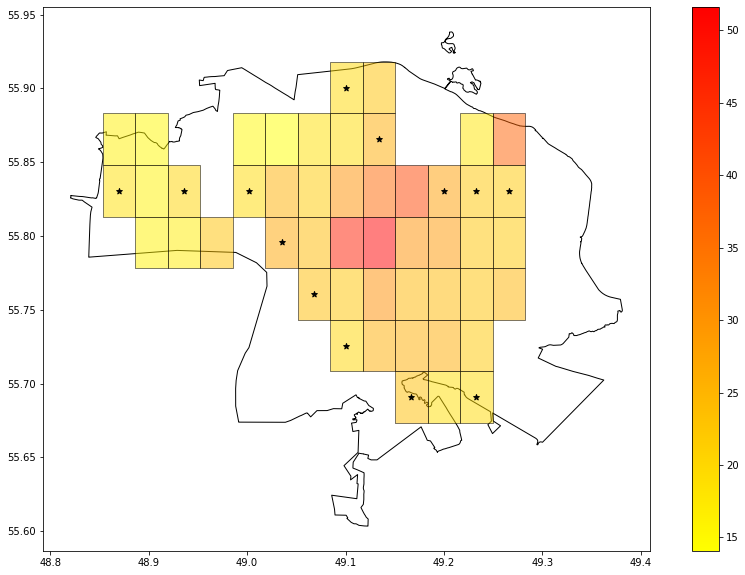

In [98]:
fig, ax = plt.subplots(figsize=(15, 10))
layer.plot(ax = ax, color='white', edgecolor='black', aspect=1.5)
t_gdf = pd.concat([gdf_p, gen_gdf], axis=0)
t_gdf.plot(ax=ax, alpha=0.5, column='mean_price', legend=True, edgecolor="black", cmap="autumn_r", aspect=1.5)
markers.plot(ax=ax, marker="*", c="black", aspect=1.5)
pass


## Looks much better!
I think this map covers more than a half of living area in City.

I can’t say how accurate this map is, since I don’t know the real data in these areas, and the apartments in these areas may differ from the neighboring ones, on the basis of which the data was generated. But if we assume that the generated data is similar to the real one, then this map is not far from the truth.

The averages on the generated data look organic with the real ones.


## Also

It is incorrect to say that this data describes rental prices in these areas.

For accuracy, it should be said that these data describe rental prices at the end of September, according to the ads posted on the Avito website.

## Thanks for reading my work!
This was my little research, the purpose of which was to observe the prices for rent in the Kazan city.
